In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
import plotly.io as pio
pio.renderers.default = "svg"

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [2]:
%%script false --no-raise-error
filename = "../../../pylec/studies/data/Synthetic.Household.Profiles.h5"
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    df = pd.read_hdf(filename, "TimeSeries")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    houseinfo = pd.read_hdf(filename, "HouseInfo")
mask = (houseinfo.Country == "France") & (houseinfo.Nmonths == "12")
df = df.loc[:, [str(a) for a in houseinfo[mask].pdIndex.tolist()]]

df["Index"] = pd.date_range(
    start="01-01-2019 00:00:00", end="31-12-2019 23:45:00", freq="15T"
)
df.set_index("Index", drop=True, inplace=True)

# --------------------------------------------
dateparse = lambda x: datetime.strptime(x, '%Y%m%d:%H%M')
pv = pd.read_csv("Timeseries_44.931_4.896_SA_1kWp_crystSi_14_38deg_-3deg_2014_2015.csv",
                 parse_dates=[0], index_col=[0], header=8, skipfooter=13, engine='python',
                 date_parser=dateparse)
# P is in W for a 1kW PV so we just have to change it to kW to get the coef 
pv = pv[['P']] / 1000
pv.columns = ["pv_1kw"]
pv = pv.loc['2014-01-01 00:00:00':'2015-01-01 00:10:00', :]

# Shifting things by 11 min, but whatever.
pv['Index'] = pd.date_range(start='2019-01-01 00:00:00',
                            end='2020-01-01 00:00:00', freq='60T')
pv.set_index('Index', drop=True, inplace=True)

# Interpolating to get 15-min interval values
pv = pv.resample('15T').interpolate('time')
pv.drop(pv.tail(1).index, inplace=True)

# --------------------------------------------
df["pv_1kw"] = pv["pv_1kw"]
df.to_pickle("fr_quoilin_data_valence.pickle")

In [3]:
df = pd.read_pickle("fr_quoilin_data_valence.pickle")
df.head()

,2000900,2000901,2000903,2000904,2000905,2000906,2000907,2000908,2000909,2000910,...,2001188,2001189,2001190,2001192,2001193,2001194,2001195,2001197,2001199,pv_1kw
Index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.295204,0.327625,0.483190,0.687899,0.143035,0.221557,0.224354,0.348925,2.359406,0.116382,...,0.079687,0.757643,0.080509,0.546715,0.026350,0.145583,0.160894,0.079701,1.420406,0.0
2019-01-01 00:15:00,0.223572,0.519240,0.236277,0.976978,0.178788,0.245871,0.485754,0.131845,1.064770,0.102974,...,0.269552,1.211409,0.074367,0.528931,0.057051,0.128810,0.155660,0.113194,0.641011,0.0
2019-01-01 00:30:00,0.237445,0.397812,0.151005,0.742844,0.232710,0.277901,0.594242,0.080997,0.897831,0.068910,...,0.107144,1.195561,0.083457,0.640498,0.069793,0.086199,0.188493,0.086067,0.540511,0.0
2019-01-01 00:45:00,0.477201,0.397999,0.398284,0.587097,0.285982,0.267720,0.512216,0.141001,1.433766,0.063750,...,0.165818,1.145802,0.107888,0.544124,0.060159,0.079745,0.160131,0.068022,0.863154,0.0
2019-01-01 01:00:00,0.415664,0.275134,0.108359,0.789470,0.181792,0.258787,0.185333,0.127379,1.140404,0.069257,...,0.250045,1.544101,0.036674,0.560161,0.031038,0.084432,0.178843,0.090153,0.814874,0.0


# Set study on 20 households

In [4]:
nb_houses = 20

In [5]:
house_ids=[
    "2000989",
    "2001197",
    "2000914",
    "2001123",
    "2000964",
    "2001189",
    "2001111",
    "2001179",
    "2000909",
    "2000918",
    "2000994",
    "2001107",
    "2000913",
    "2001139",
    "2000960",
    "2001149",
    "2001165",
    "2000954",
    "2001114",
    "2000926",
]
df = df[house_ids + ["pv_1kw"]]
print(f"Average consumption is {round((df[house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")
df.head()

Average consumption is 5.56 MWh


,2000989,2001197,2000914,2001123,2000964,2001189,2001111,2001179,2000909,2000918,...,2001107,2000913,2001139,2000960,2001149,2001165,2000954,2001114,2000926,pv_1kw
Index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.420397,0.079701,0.857910,0.031886,0.181189,0.757643,0.190965,0.227143,2.359406,0.055817,...,0.070520,0.142502,0.255521,0.582962,0.180451,1.942729,3.863059,0.121460,0.469955,0.0
2019-01-01 00:15:00,0.545898,0.113194,1.250317,0.141971,0.137223,1.211409,0.093381,0.188724,1.064770,0.061609,...,0.088147,0.223753,0.345453,0.525038,0.200254,3.050416,5.486453,0.134062,0.684911,0.0
2019-01-01 00:30:00,0.434237,0.086067,1.391707,0.100812,0.145738,1.195561,0.059680,0.132277,0.897831,0.050262,...,0.114732,0.041090,0.326808,1.252299,0.226341,0.560178,4.171616,0.109371,0.762364,0.0
2019-01-01 00:45:00,0.282571,0.068022,1.058611,0.039150,0.292894,1.145802,0.157409,0.154381,1.433766,0.044647,...,0.140997,0.281691,0.546796,0.521619,0.218049,3.840278,3.296981,0.097153,0.579897,0.0
2019-01-01 01:00:00,0.269873,0.090153,0.930174,0.074543,0.215576,1.544101,0.051027,0.251023,1.140404,0.037189,...,0.085866,0.043304,0.188321,0.512975,0.145118,0.313930,4.377657,0.073465,0.317332,0.0


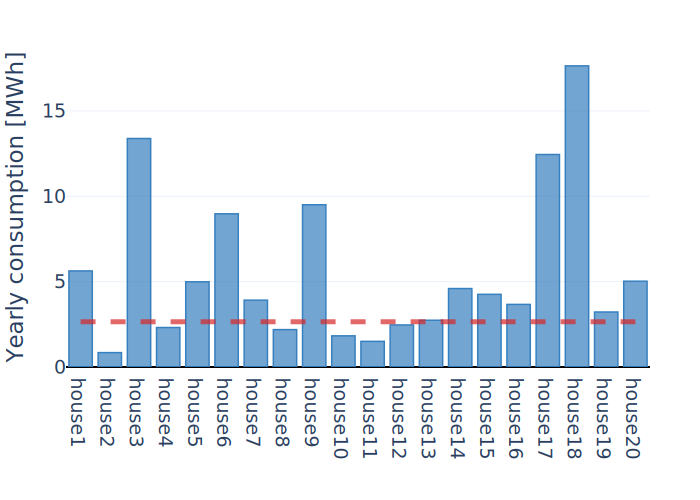

In [6]:
graph = df[[col for col in df.columns if "pv_1kw" not in col]].copy()
graph.columns = ["house" + str(n) for n in range(1, len(graph.columns) + 1)]
fig = px.bar(graph.sum() * 15 / 60 / 1000)
fig.data[0].update(
    {'marker': {'color': 'rgba(55, 128, 191, 0.7)',
                'line': {'width': 1.5,
                'color': 'rgba(55, 128, 191, 1.0)'}}})

# 'Reference for 100m2, 4 people, no elec. heating'
fig.add_shape(
  type='line',
  y0=2650/1000, y1=2650/1000, x0="house1", x1="house20",
  line={'dash': 'dash', 'width': 5,
        'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Yearly consumption [MWh]")
fig.show()

In [7]:
df.describe().T[["mean", "min", "max"]]

,mean,min,max
2000989,0.642409,0.009760,15.452793
2001197,0.096313,0.002070,2.248960
2000914,1.527877,0.007914,73.415019
2001123,0.264018,0.010254,8.702582
2000964,0.569726,0.018387,17.223078
2001189,1.024281,0.014418,34.618334
2001111,0.446941,0.011408,9.133565
2001179,0.250011,0.008664,4.353821
2000909,1.084943,0.015853,23.098691
2000918,0.208345,0.004761,7.726401


In [8]:
df["community_kW"] = df[house_ids].sum(axis=1)
df.drop(house_ids, axis=1, inplace=True)

In [9]:
df.head()

,pv_1kw,community_kW
Index,,
2019-01-01 00:00:00,0.0,12.930472
2019-01-01 00:15:00,0.0,15.765637
2019-01-01 00:30:00,0.0,12.099126
2019-01-01 00:45:00,0.0,14.475988
2019-01-01 01:00:00,0.0,10.696315


# Data reduction to 5 weeks

In [10]:
import numpy as np
import pandas as pd
from scipy.cluster.vq import whiten, vq

from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
from sklearn import preprocessing



class Clustering:
    """
    Class for simulation time period reduction using clustering
    (sklearn approach)
    """
    def __init__(self, data):
        """

        :param data: dataframe with at least the following columns
        [ cons_kw , coef_1kw ,   co2_kg_kwh ]
        """
        self.data = data
        self.observation_info = None

    def reshape_data(self, observation_size: int = 7,
                         pre_process: bool = True, freq="1D"):

        """
        Method to reshape process data into a numpy array of m * n shape
        :param observation_size: size of each observation (given in days)
        :param pre_process:  Boolean value to determine if the data for clustering should
        undergo pre processing
        :return: numpy array of m * n shape
        """

        if pre_process == True:

            data = preprocessing.minmax_scale(self.data.copy())
            data = pd.DataFrame(data, columns=self.data.columns, index=self.data.index)
        else:
            data = self.data.copy()
        ranges = pd.date_range(start=data.index[0].date(),
                               end=data.index[-1].date(), freq=freq)
        new_data = []
        observation_info = {}
        for i in range(len(ranges) - 1):
            if i + observation_size < len(ranges):
                new_data.append(data.loc[ranges[i]: ranges[i + observation_size]].copy().values)
                observation_info[i] = [ranges[i], ranges[i + observation_size]]
        new_data = np.array(new_data)

        shp = new_data.shape
        new_data = whiten(new_data)
        new_data = new_data.reshape(shp[0], shp[1] * shp[2])

        self.observation_info = observation_info
        # print (new_data.shape)
        return new_data

    def get_weights(self, data, centres, closest, n_clusters):
        """

        :param data: numpy array of m * n shape
        :param centres: list of  index of centroids
        :param closest: list of  index of selected observations
        :param n_clusters: number of clusters
        :return: dictionary of chosen observations and corresponding weights
        """
        coeff_norm = 52 / len(data)
        indx, _ = vq(data, centres)
        indx = np.bincount(indx).tolist()
        weights = {}

        for i in range(n_clusters):
            weights[closest[i]] = coeff_norm * indx[i]

        return weights

    def selected_clusters(self, closest):
        """

        :param closest: list of  index of selected observations
        :return: dataframe of selected observations
        """

        labels = self.observation_info
        df = pd.DataFrame()
        for value in closest:

            temp = self.data.loc[labels[value][0]: labels[value][1]].copy()
            temp["cluster"] = [value] * len(temp)

            if len(df) == 0:

                df = temp
            else:
                df = pd.concat([df, temp])

        return df

    def cluster(self, data, n_clusters):
        """

        :param data: numpy array of m * n shape
        :param n_clusters: number of clusters
        :return: dataframe of selected observations , dictionary of chosen
        observations and corresponding weights
        """

        kmeans = KMeans(n_clusters=n_clusters, init='k-means++',
                        n_init=42, max_iter=300, tol=1e-15).fit(data)
        centres = kmeans.cluster_centers_
        closest = pairwise_distances_argmin_min(centres, data)[0]

        clusters = self.selected_clusters(closest)
        weights = self.get_weights(data, centres, closest, n_clusters)

        return clusters, weights

    def make_pickle(self, df, filepath: str = "../../data/", file_name: str = "clustered_data_DE_.pickle"):
        """

        :param df: dataframe to be pickled
        :param filepath: directory where file is to be stored
        :param file_name: desired file name
        :return:
        """
        df.sort_index().to_pickle(filepath + file_name)

    def make_csv(self, df, filepath: str = "../../data/", file_name: str = "clustered_data_DE_.csv"):
        """

        :param df: dataframe to be pickled
        :param filepath: directory where file is to be stored
        :param file_name: desired file name
        :return:
        """
        df.sort_index().to_csv(filepath + file_name, sep=",", decimal='.', index=True)


comment %% to run KElbow method. Unclear if relevant.

In [11]:
%%script false --no-raise-error
from yellowbrick.cluster import KElbowVisualizer

model = Clustering(df.copy())
reshaped_data = model.reshape_data(observation_size=1, freq="7D")  # observation_size=1, freq="7D"
test_model = KMeans(init='k-means++',n_init=42, max_iter=300, tol=1e-15)
visualizer = KElbowVisualizer(test_model, k=(2,30), timings=True)
visualizer.fit(reshaped_data)
visualizer.show() 

In [12]:
def self_consumption_production(df, cons_col, prod_col, timing):
    """Return self-consumption and self-production in %"""
    result = {}
    local = df[[cons_col, prod_col]].groupby(pd.Grouper(freq=timing)).sum().min(axis=1).sum()  # unit do not matter
    result[f"self_cons"] = local * 100 / df[prod_col].sum()
    result[f"self_prod"] = local * 100 / df[cons_col].sum()
    return result

In [13]:
pv_sizes = list(np.linspace(0.1, 4, 100))
self_prod = {}
self_cons = {}
for timing in ["15T", "365D"]:
    self_prod[timing] = []
    self_cons[timing] = []
    for pv_size in pv_sizes:
        graph = df.copy()
        graph.pv_1kw *= nb_houses * pv_size
        res = self_consumption_production(graph, cons_col="community_kW", prod_col="pv_1kw", timing=timing)
        self_prod[timing].append(res['self_prod'])
        self_cons[timing].append(res['self_cons'])
reference = pd.DataFrame(index=pv_sizes, data=self_prod)

In [27]:
model = Clustering(df.copy())
reshaped_data = model.reshape_data(observation_size=1, freq="7D")  # observation_size=1, freq="7D"

pv_sizes = list(np.linspace(0.1, 4, 100))
self_prod = {}
self_cons = {}
print(f"Actual consumption = {round(df['community_kW'].sum() /4, 3)} kWh & {round(df['pv_1kw'].sum() /4, 3)}")
print("----")
for n_cluster in range(1, 10):
    self_prod[n_cluster] = []
    self_cons[n_cluster] = []
    
    clusters, weights = model.cluster(data=reshaped_data, n_clusters=n_cluster)
    clusters["weight"] = clusters.cluster.apply(lambda x: weights[x])
    clusters["community_kW"] *= clusters["weight"]
    clusters["pv_1kw"] *= clusters["weight"]

    cons_coef = df['community_kW'].sum() / clusters['community_kW'].sum()
    prod_coef = df['pv_1kw'].sum() / clusters['pv_1kw'].sum()
    print(f"{n_cluster} = {round(clusters['community_kW'].sum() /4, 3)} kWh & {round(clusters['pv_1kw'].sum() /4, 3)} -> {round(cons_coef, 3)}, {round(prod_coef, 3)}")
    clusters["community_kW"] *= cons_coef
    clusters["pv_1kw"] *= prod_coef
    
    for pv_size in pv_sizes:
        graph = clusters.copy()
        graph.pv_1kw *= nb_houses * pv_size
        res = self_consumption_production(graph, cons_col="community_kW", prod_col="pv_1kw", timing="15T")
        self_prod[n_cluster].append(res['self_prod'])
        self_cons[n_cluster].append(res['self_cons'])

/Users/jonathan/virtualenvs/jonathan/lib/python3.8/site-packages/scipy/cluster/vq.py:135: RuntimeWarning:

Some columns have standard deviation zero. The values of these columns will not change.



Actual consumption = 111124.6 kWh & 1367.925
----
1 = 87562.869 kWh & 1416.725 -> 1.269, 0.966
2 = 105098.123 kWh & 1235.08 -> 1.057, 1.108
3 = 106356.742 kWh & 1499.284 -> 1.045, 0.912
4 = 102948.071 kWh & 1448.442 -> 1.079, 0.944
5 = 103642.202 kWh & 1578.421 -> 1.072, 0.867
6 = 106435.578 kWh & 1359.854 -> 1.044, 1.006
7 = 106330.641 kWh & 1560.992 -> 1.045, 0.876
8 = 107117.139 kWh & 1472.864 -> 1.037, 0.929
9 = 107389.158 kWh & 1436.738 -> 1.035, 0.952


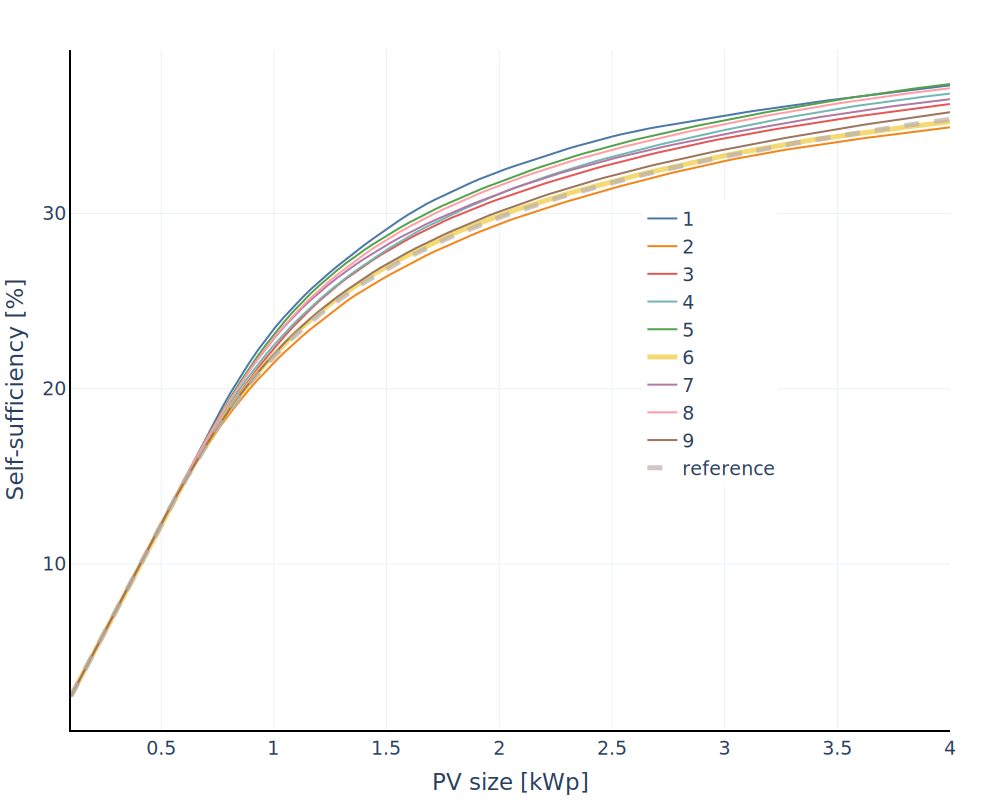

In [28]:
graph = pd.DataFrame(index=pv_sizes, data=self_prod)
graph["reference"] = reference["15T"]
_fig = px.line(graph)
_fig.update_traces(line_width=2)
_fig.data[5].update(line_width=5, opacity=0.7)
_fig.data[-1].update(line_width=5, opacity=0.7, line_dash="dash")
_fig.update_layout(
    layout,
    height=800,
    width=1000,
    yaxis_title="Self-sufficiency [%]",
    yaxis_dtick=10,
    xaxis_title="PV size [kWp]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=True, xaxis_linewidth=2, xaxis_linecolor='black',
    showlegend=True,
    legend={"x": 0.65, "y": 0.78},
    legend_title="")
_fig.show()

For this dataset 6 clusters give the best representation

In [29]:
clusters, weights = model.cluster(data=reshaped_data, n_clusters=6)
clusters["weight"] = clusters.cluster.apply(lambda x: weights[x])

graph = clusters.copy()
graph["community_kW"] *= graph["weight"]
graph["pv_1kw"] *= graph["weight"]
cons_coef = df['community_kW'].sum() / graph['community_kW'].sum()
prod_coef = df['pv_1kw'].sum() / graph['pv_1kw'].sum()
print(f"{6} = {round(graph['community_kW'].sum() /4, 3)} kWh & {round(graph['pv_1kw'].sum() /4, 3)} -> {round(cons_coef, 3)}, {round(prod_coef, 3)}")

clusters["community_kW"] *= cons_coef
clusters["pv_1kw"] *= prod_coef
clusters.groupby("cluster").head(1).sort_index()

6 = 103255.617 kWh & 1391.125 -> 1.076, 0.983


,pv_1kw,community_kW,cluster,weight
Index,,,,
2019-02-05,0.0,12.960701,5,2.0
2019-03-26,0.0,12.104212,12,9.0
2019-08-06,0.0,4.074024,31,15.0
2019-09-03,0.0,6.674128,35,10.0
2019-11-12,0.0,7.833322,45,6.0
2019-12-10,0.0,11.530702,49,10.0


In [30]:
_df = df.copy()
df = clusters.sort_index().copy()
df.head()

,pv_1kw,community_kW,cluster,weight
Index,,,,
2019-02-05 00:00:00,0.0,12.960701,5,2.0
2019-02-05 00:15:00,0.0,13.312236,5,2.0
2019-02-05 00:30:00,0.0,13.315688,5,2.0
2019-02-05 00:45:00,0.0,12.490945,5,2.0
2019-02-05 01:00:00,0.0,10.938124,5,2.0


In [31]:
print(f"Actual consumption = {round(_df['community_kW'].sum() /4, 3)} kWh")
print(f"New consumption = {round((df.weight * df['community_kW']).sum() /4, 3)} kWh")

Actual consumption = 111124.6 kWh
New consumption = 111124.6 kWh


# Get the natural self-sufficiency

PV that produces all energy consumption would be 81.24 kWp
Self-consumption = 34.71 % 
Self-sufficiency = 34.71 %


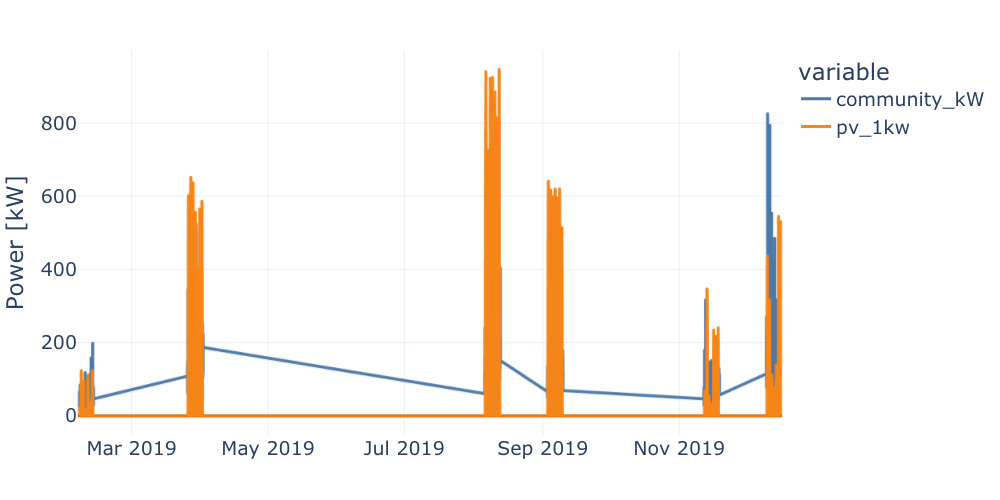

In [33]:
graph = df.loc[:, ["community_kW", "pv_1kw", "weight"]].copy()
graph["community_kW"] *= graph["weight"]
graph["pv_1kw"] *= graph["weight"]

breakpoint_pv = graph["community_kW"].sum() / graph["pv_1kw"].sum()
print(f"PV that produces all energy consumption would be {round(breakpoint_pv, 2)} kWp")

graph.pv_1kw *= breakpoint_pv
res = self_consumption_production(graph, cons_col="community_kW", prod_col="pv_1kw", timing="15T")
print(f"Self-consumption = {round(res['self_cons'], 2)} % \nSelf-sufficiency = {round(res['self_prod'], 2)} %")

fig = px.line(graph[["community_kW", "pv_1kw"]])
fig.update_traces(line_width=3)
fig.update_layout(layout, width=1000, yaxis_title="Power [kW]", xaxis_title="")
fig.show(renderer="png")

# Natural self-sufficiency is defined when `energy consumed = energy produced`

Building a new "profile".

$$
\Large profile(t) = consumption(t) + profile_{change}(t) \\
\Large 0 \leq profile(t) \leq \max(consumption(t)) \\
\Large \sum^T_t profile_{change}(t) \times weight(t) = 0 \\
$$

Calculating self-sufficiency (turns the problem into a MILP).

$$
\Large grid^+(t) - grid^-(t) = profile(t) - pv \times irradiance(t) \\
\Large 0 \leq grid^+(t) \leq \delta \times \max(consumption(t)) \\
\Large 0 \leq grid^-(t) \leq (1 - \delta ) \times pv \times irradiance(t) \\
\Large \frac{\sum^T_t weight(t) \times grid^+(t)}{\sum^T_t weight(t) \times consumption(t)} = 1 - target^{self} \\
$$

Objective function
$$
\Large \sum^T_t weight(t) \times profile_{change}(t)^2 \\
$$

In [34]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass


class ProfileGenerator():
    verbose: bool = False
    solver: str = "gurobi"
    time_limit: int = 5 * 60
    peak_load: float = 50. # <--- Enforce peak load here

    def solve(self, df, col_conso, col_prod, col_weight, pv_size, target):
        # Inputs format
        energy_cons = (df[col_conso] * df[col_weight]).sum()
        #self.peak_load = 10 * float(df.loc[:, col_conso].max())
        cons = df.loc[:, [col_conso]].copy().reset_index()[col_conso].to_dict()
        irradiance = df.loc[:, [col_prod]].copy().reset_index()[col_prod].to_dict()
        weight = df.loc[:, [col_weight]].copy().reset_index()[col_weight].to_dict()
        
        # Model parameters
        m = ConcreteModel()
        m.horizon = Set(initialize=list(cons.keys()), ordered=True)
        
        # Variables to match a given self-sufficiency
        m.profile_change = Var(m.horizon)
        m.profile = Var(m.horizon, domain=NonNegativeReals)
        m.grid_plus = Var(m.horizon, domain=NonNegativeReals)
        m.grid_minus = Var(m.horizon, domain=NonNegativeReals)
        m.delta = Var(m.horizon, domain=Binary)
        
        # Constraints
        def r_likeprofile(m, t):
            return m.profile[t] == cons[t] + m.profile_change[t]
        
        def r_sum_of_change(m):
            return sum(m.profile_change[t] * weight[t] for t in m.horizon) == 0
        
        def r_max_change(m, t):
            return m.profile[t] <= self.peak_load
        
        def r_netload(m, t):
            return (m.grid_plus[t] - m.grid_minus[t] == 
                m.profile[t] - pv_size * irradiance[t]
            )
        
        def r_self_suff(m):
            return (  
                sum(weight[t] * m.grid_plus[t] for t in m.horizon)
                / energy_cons
                == 1 - target
            )

        def r_grid_plus(m, t):
            return m.grid_plus[t] <= m.delta[t] * self.peak_load
        
        def r_grid_minus(m, t):
            return m.grid_minus[t] <= (1 - m.delta[t]) * pv_size * irradiance[t]
        
        m.r1 = Constraint(m.horizon, rule=r_likeprofile)
        m.r2 = Constraint(rule=r_sum_of_change)
        m.r3 = Constraint(m.horizon, rule=r_netload)
        m.r4 = Constraint(rule=r_self_suff)
        m.r5 = Constraint(m.horizon, rule=r_max_change)
        m.r6 = Constraint(m.horizon, rule=r_grid_plus)
        m.r7 = Constraint(m.horizon, rule=r_grid_minus)
        
        # Objective
        def objective_function(m):
            return sum(weight[t] * m.profile_change[t]**2 for t in m.horizon)                    
        m.objective = Objective(rule=objective_function, sense=minimize)

        with SolverFactory(self.solver) as opt:
            if self.solver == "glpk":
                termination = 'tmlim'
            else:
                termination = 'TimeLimit'
            results = opt.solve(m, tee=self.verbose, options={termination: self.time_limit})
        
        # A bunch of prints in case of an error.
        if ((results.solver.status == SolverStatus.ok) and 
        (results.solver.termination_condition == TerminationCondition.optimal)):
            pass
        elif (results.solver.termination_condition == TerminationCondition.infeasible):
            print(f"Solver termination condition:  {results.solver.termination_condition}")
        else:
            print(f"Solver Status:  {results.solver.status}")
            print(f"Solver termination condition:  {results.solver.termination_condition}")
        return m
    
def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if not hasattr(var.index_set(), '_implicit_subsets'):
            results[var.name] = getattr(model, var.name).get_values()[None]
        elif var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            if len(timeindex) == len(results[var.name].index):
                results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            if len(timeindex) == len(results[var.name].index):
                results[var.name].index = timeindex
    return results

# Run from 10% to 90% natural self-sufficiency

In [35]:
import copy

model = ProfileGenerator()
model.verbose = False
model.time_limit = int(2 * 60)
model.peak_load = float(df.loc[:, "community_kW"].max())
targets = [10, 20, 30, 40, 50, 60, 70, 80, 90]

results = []
for target in targets: 
    print("")
    print("##############")
    print(f"target = {target}%")
    result = model.solve(df, "community_kW", "pv_1kw", "weight", pv_size=breakpoint_pv, target=target/100)
    result = get_timevar_from_pyomo(result, df.index)
    
    tmp = result["profile"].copy()
    tmp.columns = ["community_kW"]
    tmp["pv_1kw"] = df.pv_1kw
    tmp["weight"] = df.weight
    tmp["cluster"] = df.cluster
    
    # Summary
    rm = tmp.copy()
    rm["pv_1kw"] *= breakpoint_pv
    rm["community_kW"] *= df.weight
    rm["pv_1kw"] *= df.weight
    res = self_consumption_production(rm, cons_col="community_kW", prod_col="pv_1kw", timing="15T")
    print(f"""
    Target = {target}%
    Actual = {round(res['self_prod'], 2)}%""")
    print(f"""
    Target consumption = {round((df.weight * df["community_kW"]).sum() /4, 3)} kWh
    Weighted consumption = {round(rm["community_kW"].sum() /4, 3)} kWh
    """)

    # Save
    results.append(tmp.copy()) 


##############
target = 10%
    containing a solution
Solver Status:  aborted
Solver termination condition:  maxTimeLimit

    Target = 10%
    Actual = 10.0%

    Target consumption = 111124.6 kWh
    Weighted consumption = 111124.6 kWh
    

##############
target = 20%
    containing a solution
Solver Status:  aborted
Solver termination condition:  maxTimeLimit

    Target = 20%
    Actual = 20.0%

    Target consumption = 111124.6 kWh
    Weighted consumption = 111124.6 kWh
    

##############
target = 30%
    containing a solution
Solver Status:  aborted
Solver termination condition:  maxTimeLimit

    Target = 30%
    Actual = 30.0%

    Target consumption = 111124.6 kWh
    Weighted consumption = 111124.6 kWh
    

##############
target = 40%

    Target = 40%
    Actual = 40.0%

    Target consumption = 111124.6 kWh
    Weighted consumption = 111124.6 kWh
    

##############
target = 50%

    Target = 50%
    Actual = 50.0%

    Target consumption = 111124.6 kWh
    Weighted 

In [37]:
# Get the reference again
pv_sizes = list(np.linspace(0.1, 4.5, 100))
self_prod = {}
self_cons = {}
for timing in ["15T", "365D"]:
    self_prod[timing] = []
    self_cons[timing] = []
    for pv_size in pv_sizes:
        graph = _df.copy()
        graph.pv_1kw *= nb_houses * pv_size
        res = self_consumption_production(graph, cons_col="community_kW", prod_col="pv_1kw", timing=timing)
        self_prod[timing].append(res['self_prod'])
        self_cons[timing].append(res['self_cons'])
reference = pd.DataFrame(index=pv_sizes, data=self_prod)

In [38]:
pv_sizes = list(np.linspace(0.1, 4.5, 100))
self_prod = {}
for i, target in enumerate(targets):
    self_prod[target] = []
    for pv_size in pv_sizes:
        graph = results[i].copy()
        graph["pv_1kw"] *= nb_houses * pv_size
        graph["pv_1kw"] *= df.weight
        graph["community_kW"] *= df.weight
        res = self_consumption_production(graph, cons_col="community_kW", prod_col="pv_1kw", timing="15T")
        self_prod[target].append(res['self_prod'])

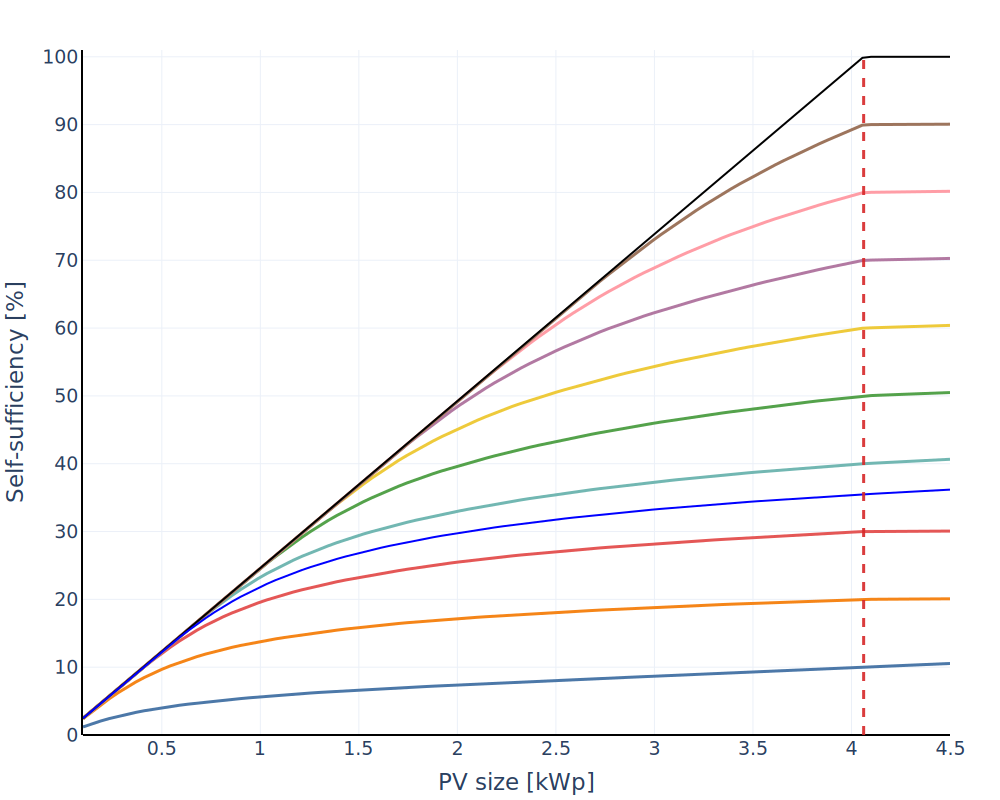

In [39]:
graph = pd.DataFrame(index=pv_sizes, data=self_prod)
fig = px.line(graph)
fig.update_traces(line_width=3)
fig.add_trace(px.line(reference["365D"]).data[0])
fig.data[-1].update(line_color="black")
fig.add_trace(px.line(reference["15T"]).data[0])
fig.data[-1].update(line_color="blue")
fig.update_layout(
    layout,
    height=800,
    width=1000,
    yaxis_title="Self-sufficiency [%]",
    yaxis_dtick=10,
    xaxis_title="PV size [kWp]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    yaxis_range=[0, 101],
    showlegend=False,
    legend={"x": 0.03, "y": 1.01},
    legend_title="")
fig.add_shape(
  type='line',
  x0=breakpoint_pv/nb_houses, x1=breakpoint_pv/nb_houses, y0=0, y1=100,
  line={'dash': 'dash', 'width': 3,
        'color': 'rgba(214, 39, 40, 0.9)'})
fig.show()

In [35]:
fig.write_image("results/result_of_NSS.svg")